<div style="text-align:center; margin-top:150px;">

# CNN CANCER DETECTION

## Duc Huynh
</div>

**INTRODUCTION**

Cancer diagnosis through histopathological images is a critical task in medical imaging. Traditionally, pathologists examine cell structures under a microscope to identify abnormalities. However, this process is time-consuming, subjective, and prone to human error. With the rise of deep learning, particularly Convolutional Neural Networks (CNNs), we now have powerful tools to automate and enhance the accuracy of cancer detection.

The goal of this project is to build a CNN model that can classify microscopic cell images into two categories: cancerous and non-cancerous. This binary classification task will help in early detection and diagnosis, potentially improving patient outcomes.

**DATA PREPROCESSING**

In [1]:
import numpy as np
import pandas as pd 
import os

# Initialize list to store .tif file paths
tif_files= []

# Walk through all directories under /kaggle/input
for dirpath, _, filenames in os.walk('/kaggle/input'):
    print(f"\nDirectory:{dirpath}")
    tif_count =0
    for filename in filenames:
        if filename.endswith('.tif'):
            tif_count+= 1
            if tif_count<= 2:
                print(os.path.join(dirpath,filename))
            elif tif_count== 3:
                print("...")
        else:
            print(os.path.join(dirpath,filename))
    if tif_count> 0:
        print(f"Total .tif files in this directory:{tif_count}")


Directory:/kaggle/input

Directory:/kaggle/input/histopathologic-cancer-detection
/kaggle/input/histopathologic-cancer-detection/sample_submission.csv
/kaggle/input/histopathologic-cancer-detection/train_labels.csv

Directory:/kaggle/input/histopathologic-cancer-detection/test
/kaggle/input/histopathologic-cancer-detection/test/a7ea26360815d8492433b14cd8318607bcf99d9e.tif
/kaggle/input/histopathologic-cancer-detection/test/59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
...
Total .tif files in this directory:57458

Directory:/kaggle/input/histopathologic-cancer-detection/train
/kaggle/input/histopathologic-cancer-detection/train/d43c081bafa286f9c1f7e921883f26ceafebc912.tif
/kaggle/input/histopathologic-cancer-detection/train/092d0eedebce504847715ee046b6ad74b57599b4.tif
...
Total .tif files in this directory:220025


The train dataset contains 220,025 and test dataset contains 57458 patches of breast tissue images labeling 0 (non-cancerous) and 1 (cancerous). Now let's take a look of how our images look like:

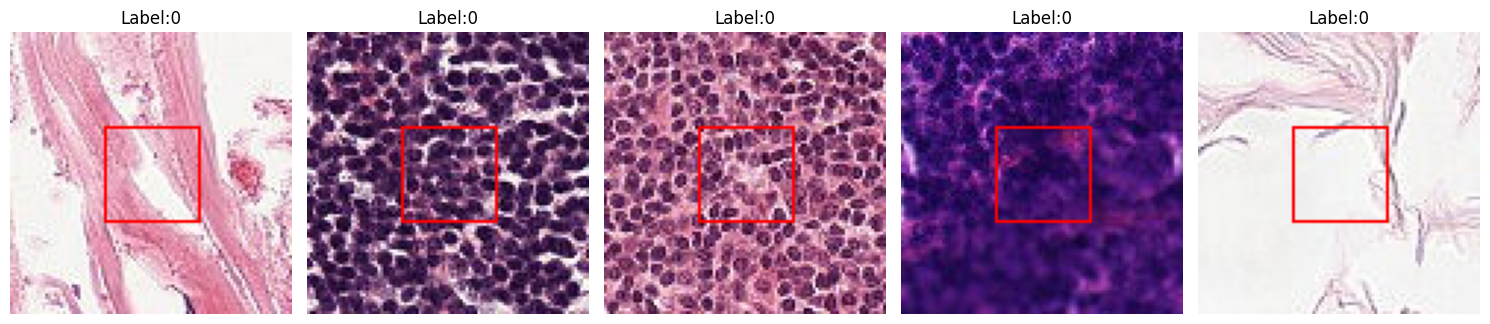

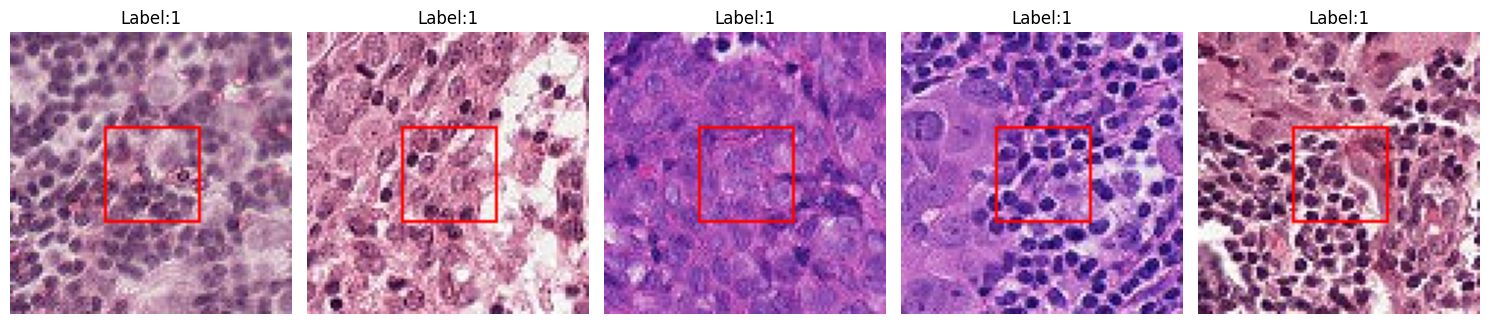

In [2]:
import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

# Define image directory and load label data
image_root= Path("/kaggle/input/histopathologic-cancer-detection/train")
labels_df =pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")

# Append full image paths to the dataframe
labels_df["filepath"]= labels_df["id"].apply(lambda img_id: image_root/f"{img_id}.tif")
def visualize_samples(target_label,data=labels_df,count=5):
    selected= data.query("label== @target_label").sample(n=count,random_state=42)
    fig, axes =plt.subplots(1,count,figsize=(15, 4))
    for ax,(_,row) in zip(axes,selected.iterrows()):
        image= cv2.imread(str(row["filepath"]))
        image= cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

        # Draw a rectangle in the center
        top_left= (32, 32)
        bottom_right =(64, 64)
        cv2.rectangle(image,top_left,bottom_right,color=(255, 0, 0), thickness=1)
        ax.imshow(image)
        ax.set_title(f"Label:{row['label']}")
        ax.axis("off")
    plt.tight_layout()
visualize_samples(0)
visualize_samples(1)

Now we will split data into 80% training and 20% validation:

In [3]:
from sklearn.model_selection import train_test_split

#Split the dataset
train_df, val_df= train_test_split(
    labels_df,
    test_size=0.2,
    random_state=42,
    stratify=labels_df["label"])

# Save to working directory
train_df.to_csv("/kaggle/working/train_split.csv",index=False)
val_df.to_csv("/kaggle/working/val_split.csv",index=False)

# Print summary
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

Training samples: 176020
Validation samples: 44005


Data generators:

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Convert label columns to string type
for df in [train_df, val_df]:
    df['label']= df['label'].map(str)

# Generate filenames by appending '.tif' to image IDs
for df in [train_df, val_df]:
    df['filename']= df['id'].apply(lambda img_id:f"{img_id}.tif")

# Define image preprocessing pipelines
augment_config =ImageDataGenerator(
    rescale=1/255.0,
    horizontal_flip=True,
    vertical_flip=True)
basic_config= ImageDataGenerator(rescale=1/255.0)

# Build data loaders from dataframes
train_loader= augment_config.flow_from_dataframe(
    dataframe=train_df,
    directory=image_root,
    x_col='filename',
    y_col='label',
    target_size=(96,96),
    batch_size=32,
    class_mode='binary')

val_loader=basic_config.flow_from_dataframe(
    dataframe=val_df,
    directory=image_root,
    x_col='filename',
    y_col='label',
    target_size=(96,96),
    batch_size=32,
    class_mode='binary')

2025-10-02 14:57:32.954967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759417053.179279     397 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759417053.248226     397 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


**CNN MODEL BUILDING**

**Basic CNN Model:**

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,Dropout, Flatten, Dense

def build_simple_cnn():
    inputs= Input(shape=(96,96,3),name='input_layer')
    x = Conv2D(32,kernel_size=(3,3),activation='relu',name='conv_1')(inputs)
    x = MaxPooling2D(pool_size=(2,2),name='pool_1')(x)
    x = Conv2D(64,kernel_size=(3,3),activation='relu',name='conv_2')(x)
    x = MaxPooling2D(pool_size=(2,2),name='pool_2')(x)
    x = Flatten(name='flatten')(x)
    x = Dense(128,activation='relu',name='dense_1')(x)
    outputs=Dense(1,activation='sigmoid',name='output_layer')(x)
    simple_cnn_model=Model(inputs=inputs,outputs=outputs,name='SimpleCNN')
    return simple_cnn_model

# Instantiate and display model architecture
basic_classifier=build_simple_cnn()
basic_classifier.summary()


2025-10-02 14:59:53.291570: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "SimpleCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Compile the basic CNN model
basic_classifier.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

# Train the basic CNN model
training_history_basic= basic_classifier.fit(
    train_loader,
    epochs=5,
    validation_data=val_loader)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1396s 253ms/step - accuracy: 0.7724 - loss: 0.4843 - val_accuracy: 0.7869 - val_loss: 0.4594
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1247s 227ms/step - accuracy: 0.8224 - loss: 0.3973 - val_accuracy: 0.8400 - val_loss: 0.3630
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1228s 223ms/step - accuracy: 0.8381 - loss: 0.3691 - val_accuracy: 0.8472 - val_loss: 0.3510
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1247s 227ms/step - accuracy: 0.8457 - loss: 0.3528 - val_accuracy: 0.8574 - val_loss: 0.3334
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1264s 223ms/step - accuracy: 0.8555 - loss: 0.3372 - val_accuracy: 0.8591 - val_loss: 0.3265


**Enhanced CNN Model:**

In [7]:
def build_enhanced_cnn():
    inputs=Input(shape=(96,96,3),name='input_layer')
    x= Conv2D(32,(3,3), activation='relu',name='conv_block_1')(inputs)
    x= MaxPooling2D(pool_size=(2,2),name='pool_1')(x)
    x= Dropout(0.2,name='dropout_1')(x)
    x= Conv2D(64,(3,3),activation='relu',name='conv_block_2')(x)
    x= MaxPooling2D(pool_size=(2, 2),name='pool_2')(x)
    x= Dropout(0.2,name='dropout_2')(x)
    x= Conv2D(128,(3, 3),activation='relu',name='conv_block_3')(x)
    x= MaxPooling2D(pool_size=(2, 2),name='pool_3')(x)
    x= Flatten(name='flatten')(x)
    x= Dense(256,activation='relu',name='dense_1')(x)
    x= Dropout(0.5,name='dropout_3')(x)
    outputs = Dense(1, activation='sigmoid',name='output_layer')(x)
    enhanced_cnn_model = Model(inputs=inputs,outputs=outputs,name='EnhancedCNN')
    return enhanced_cnn_model

# Instantiate and display the model architecture
enhanced_classifier= build_enhanced_cnn()
enhanced_classifier.summary()

Model: "EnhancedCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_1 (Conv2D)           │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_2 (Conv2D)           │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_3 (Conv2D)           │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,370,561 (12.86 MB)

 Trainable params: 3,370,561 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compile the enhanced CNN model
enhanced_classifier.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

# Train the enhanced CNN model
training_history_enhanced= enhanced_classifier.fit(
    train_loader,
    epochs=5,
    validation_data=val_loader)

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1620s 294ms/step - accuracy: 0.7730 - loss: 0.4855 - val_accuracy: 0.8451 - val_loss: 0.3526
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1615s 294ms/step - accuracy: 0.8480 - loss: 0.3565 - val_accuracy: 0.8667 - val_loss: 0.3137
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1590s 289ms/step - accuracy: 0.8669 - loss: 0.3192 - val_accuracy: 0.8769 - val_loss: 0.2951
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1609s 292ms/step - accuracy: 0.8725 - loss: 0.3055 - val_accuracy: 0.8826 - val_loss: 0.2788
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1609s 293ms/step - accuracy: 0.8784 - loss: 0.2944 - val_accuracy: 0.8884 - val_loss: 0.2696


**MODELS EVALUATION**

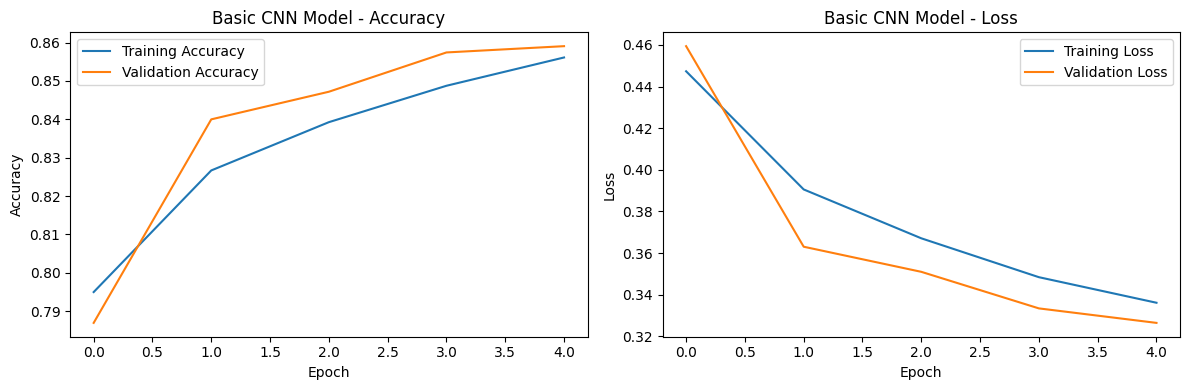

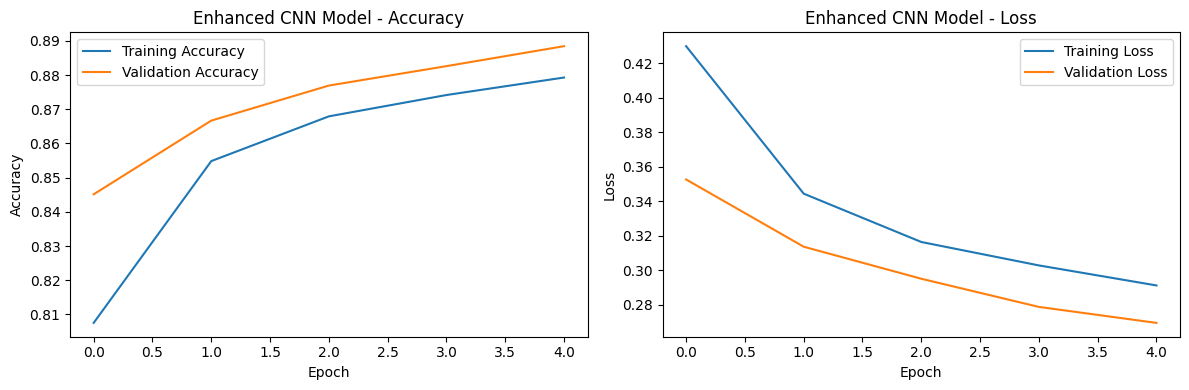

In [9]:
def visualize_training_metrics(history_data, model_name):
    plt.figure(figsize=(12,4))

    # Plot accuracy
    plt.subplot(1,2,1)
    plt.plot(history_data.history['accuracy'],label='Training Accuracy')
    plt.plot(history_data.history['val_accuracy'],label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1,2,2)
    plt.plot(history_data.history['loss'],label='Training Loss')
    plt.plot(history_data.history['val_loss'],label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Visualize training performance
visualize_training_metrics(training_history_basic,'Basic CNN Model')
visualize_training_metrics(training_history_enhanced,'Enhanced CNN Model')

Basic CNN Model:  
-Accuracy: training accuracy starts at ~0.79 and improves to ~0.84, validation accuracy begins at ~0.81, peaks at ~0.85 (epoch 2) then slightly dips to ~0.84 -> the model learns steadily, and validation accuracy closely tracks training accuracy, indicating minimal overfitting.  
-Loss: training loss decreases from ~0.44 to ~0.34, validation loss starts at ~0.42, drops sharply after epoch 1, and ends at ~0.32 -> the consistent drop in both training and validation loss suggests effective learning and generalization.  

Enhanced CNN Model:  
-Accuracy: training accuracy starts higher at ~0.83 and climbs to ~0.87, validation accuracy begins at ~0.84, peaks at ~0.88 (epoch 2) then slightly declines -> the enhanced model shows better initial performance and higher peak accuracy, suggesting improved feature extraction or architecture.  
-Loss: training loss starts at ~0.38 and drops to ~0.30, validation loss begins higher but quickly drops below training loss, stabilizing just above ~0.28 -> the lower final loss values and faster convergence indicate better optimization and generalization.  

In brief, the enhanced CNN model outperforms the basic CNN model in both accuracy and loss, showing better efficiency and generalization over the same number of epochs.

**CONCLUSION**

CNNs are effective at learning patterns in medical imaging data, such as breast tissue patches, and can distinguish between cancerous and non-cancerous samples with increasing accuracy over time. The basic model provides stable and reliable performance, making it suitable for initial deployment or low-resource environments. The enhanced model, with added layers and dropout, captures more complex features but may require more careful tuning (e.g., regularization, more data, or early stopping) to avoid overfitting.Validation performance is key: fluctuations in the enhanced model suggest that while it has higher capacity, it may also be more sensitive to noise or imbalance in the dataset.

